### Simulated

In [1]:
from scipy.ndimage.filters import gaussian_filter
from statsmodels.nonparametric.kde import kdensityfft
from matplotlib import cm
from PIL import Image
from itertools import product

In [2]:
plt = plotter()
%matplotlib inline

In [52]:
seed = 8482028
max_seed = 2**32 - 1
gen_seed = lambda st: st.randint(max_seed)

In [3]:
pixel = 15
size = 256
sigma = 2

In [4]:
norm = 300
eps = 1e-16

In [5]:
normalize = lambda x: x/(x+norm)
quantize = lambda x: (256*(x-eps)).astype(np.uint8)
rms = lambda x: np.sqrt(np.sum(x*x))

In [85]:
# generate firm locations
def gen_firms(NC, NF, CS, CW, state=np.random):
    if type(state) is int:
        state = np.random.RandomState(state)
    c_cent = 0.5 + 0.25*state.randn(NC, 2)
    c_size = state.poisson(CS, size=NC)
    f_zero = 0.5 + 0.5*state.randn(NF, 2)
    f_base = np.array([0.5, 0.5])
    f_ones = np.vstack([cc+CW*state.randn(cs, 2) for cc, cs in zip(c_cent, c_size)])
    f_locs = np.vstack([f_zero, f_ones, f_base])
    df = pd.DataFrame({'lon': f_locs[:,0], 'lat': f_locs[:,1]})
    df = df[(df['lon']>0)&(df['lon']<1)&(df['lat']>0)&(df['lat']<1)]
    return df

In [19]:
def gen_density(df):
    count, lon_bins, lat_bins = np.histogram2d(df['lon'], df['lat'], bins=size, range=((0, 1), (0, 1)))
    dens = count/(pixel/1e3)**2 # firms per square kilometer
    dens = gaussian_filter(dens, sigma=sigma)
    dimg = quantize(1-normalize(dens))
    return dimg

### Duranton

In [20]:
st = np.random.RandomState(seed)
sd0, sd1 = gen_seed(st), gen_seed(st)
df_locs1 = gen_firms(1, 200, 100, 0.05, state=sd0)
df_locs2 = gen_firms(2, 100, 100, 0.05, state=sd1)

/home/doug/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


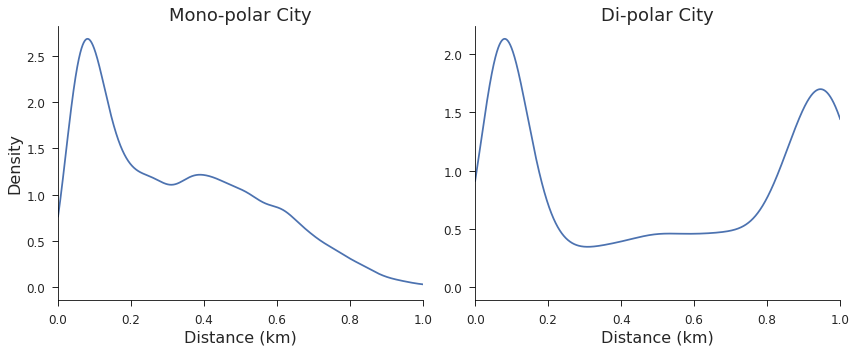

In [21]:
dist1 = pd.Series([rms(x-y) for x, y in product(df_locs1.values, df_locs1.values)])
dist2 = pd.Series([rms(x-y) for x, y in product(df_locs2.values, df_locs2.values)])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
kde_vals1, kde_grid1, kde_bw1 = kdensityfft(dist1.values)
kde_vals2, kde_grid2, kde_bw2 = kdensityfft(dist2.values)
ax1.plot(kde_grid1, kde_vals1);
ax2.plot(kde_grid2, kde_vals2);
ax1.set_xlim(0, 1);
ax2.set_xlim(0, 1);
ax1.set_xlabel('Distance (km)')
ax2.set_xlabel('Distance (km)')
ax1.set_ylabel('Density')
ax1.set_title('Mono-polar City')
ax2.set_title('Di-polar City')
fig.savefig('../slides/images/simulated_twopoint.svg')

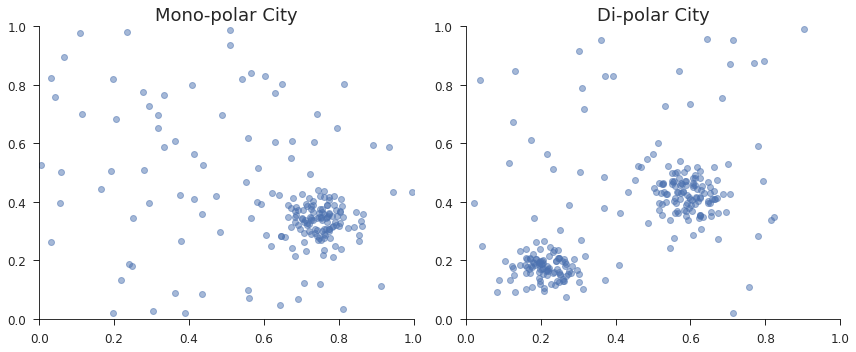

In [196]:
dimg1 = gen_density(df_locs1)
dimg2 = gen_density(df_locs2)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.scatter(*df_locs1.values.T, alpha=0.5)
ax2.scatter(*df_locs2.values.T, alpha=0.5)
ax1.set_xlim(0, 1)
ax2.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax1.set_title('Mono-polar City')
ax2.set_title('Di-polar City')
fig.savefig('../slides/images/simulated_scatter.svg')

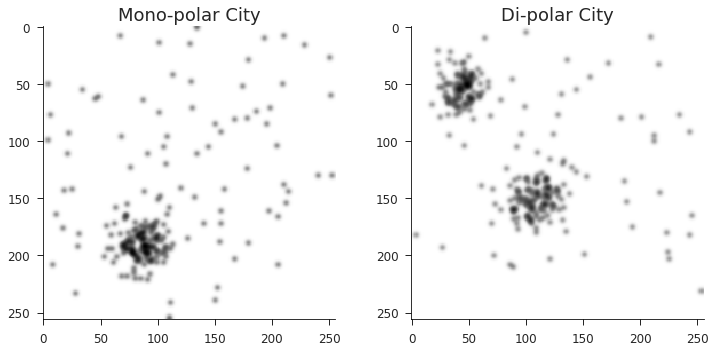

In [183]:
dimg1 = gen_density(df_locs1)
dimg2 = gen_density(df_locs2)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.imshow(dimg1, cmap=cm.Greys_r)
ax2.imshow(dimg2, cmap=cm.Greys_r)
ax1.set_title('Mono-polar City')
ax2.set_title('Di-polar City')
fig.savefig('../slides/images/simulated_density.svg')

### Example

In [86]:
df_locs = gen_firms(2, 100, 100, 0.05, state=seed)
dimg = gen_density(df_locs)

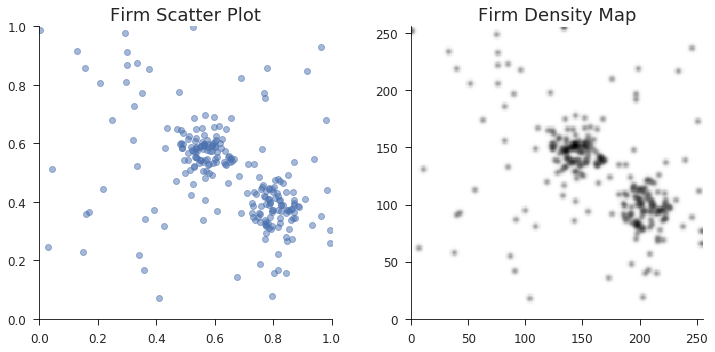

In [87]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))
ax0.scatter(*df_locs.values.T, alpha=0.5)
ax0.axis('square')
ax0.set_xlim(0, 1)
ax0.set_ylim(0, 1)
ax0.set_title('Firm Scatter Plot')
ax1.imshow(dimg.T, cmap=cm.Greys_r, origin='lower')
ax1.axis('square')
ax1.set_xlim(0, 256)
ax1.set_ylim(0, 256)
ax1.set_title('Firm Density Map')
fig.savefig('../slides/images/density_map.png', dpi=300, bbox_inches='tight')

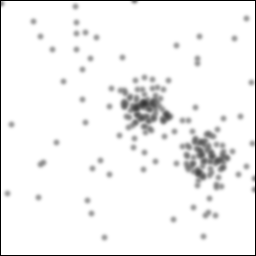

In [92]:
dimgx = dimg.copy()
dimgx[0,:] = 0
dimgx[-1,:] = 0
dimgx[:,0] = 0
dimgx[:,-1] = 0
imgx = Image.fromarray(dimgx.T[::-1,:])
imgx.save('../slides/images/cell.png')
imgx